In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import h5py
import skimage
import matplotlib.pyplot as plt
import sys
import os
from subprocess import check_output
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
%matplotlib inline

Using TensorFlow backend.


In [14]:
base_path = os.path.join("data")
train_h5_path = os.path.join(base_path, 'food_c101_n10099_r64x64x3.h5')
test_h5_path = os.path.join(base_path, 'food_test_c101_n1000_r64x64x3.h5')

In [15]:
train_data = h5py.File(train_h5_path,'r')
test_data = h5py.File(test_h5_path,'r')

In [16]:
print train_data.keys()
print len(train_data["category"])
print len(train_data["category_names"])
print len(train_data["images"])

[u'category', u'category_names', u'images']
10099
101
10099


In [17]:
X_train = train_data["images"][:2000]
y_train = train_data["category"][:2000]
print X_train.shape
print y_train.shape

(2000, 64, 64, 3)
(2000, 101)


In [18]:
X_test = test_data["images"]
y_test = test_data["category"]
print X_test.shape
print y_test.shape

(1000, 64, 64, 3)
(1000, 101)


In [19]:
sample_imgs = 25

In [20]:
idxs = slice(0, sample_imgs)

In [21]:
img_data = train_data["images"][idxs]
img_label = train_data["category"][idxs]
img_label_names = train_data["category_names"][idxs]

In [22]:
img_label_names_decode = [x.decode() for x in train_data['category_names'].value]

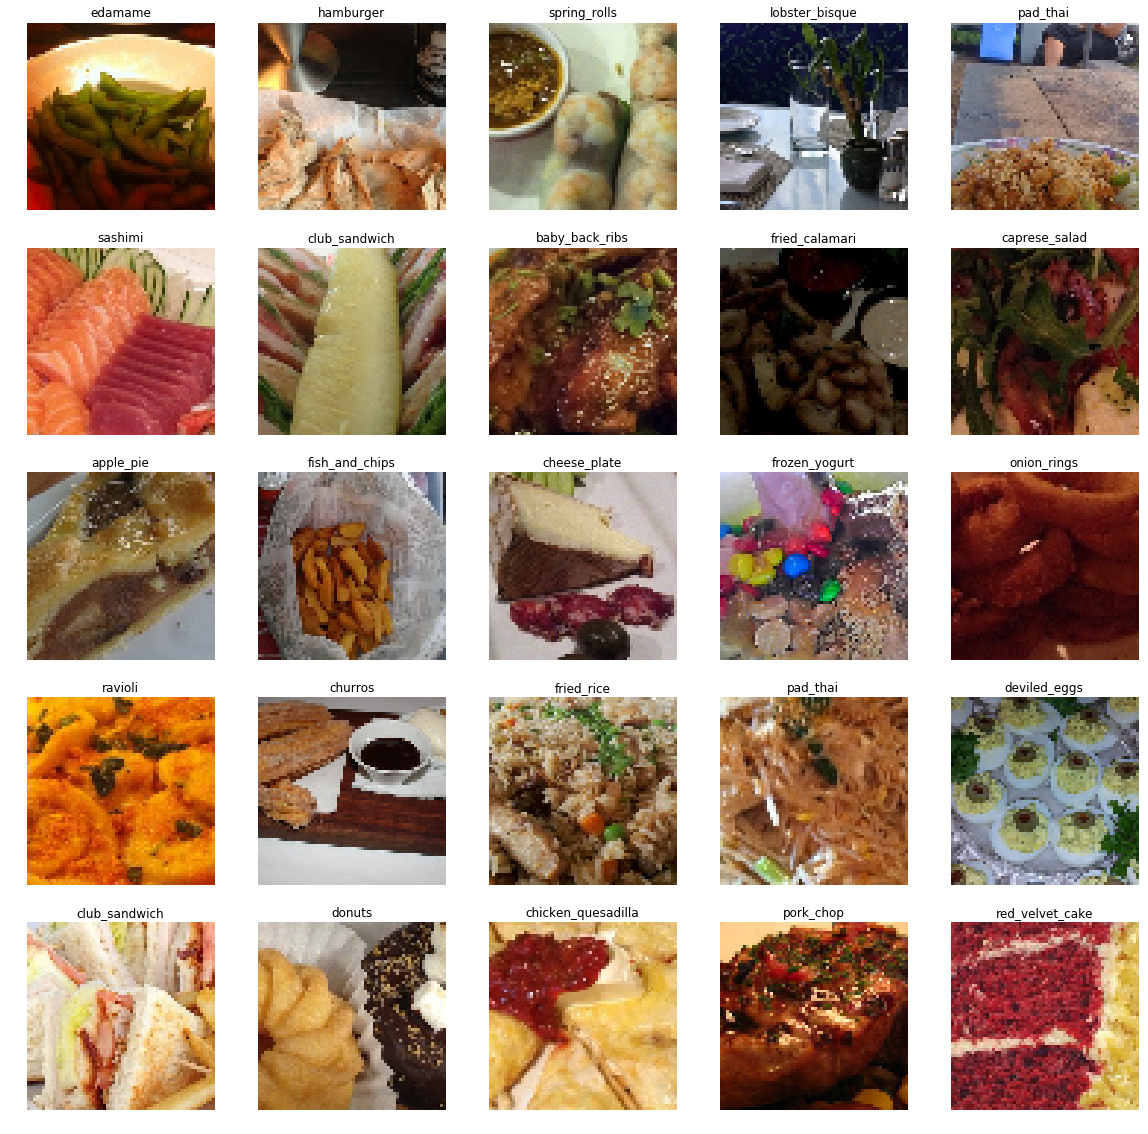

In [23]:
figure, subplots = plt.subplots(5, 5, figsize = (20, 20))
for subplot, label, image in zip(subplots.flatten(), img_label, img_data):
    subplot.imshow(image)
    subplot.axis('off')
    subplot.set_title(img_label_names_decode[np.argmax(label)])

In [25]:
from keras.applications.vgg16 import VGG16

In [26]:
model = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [27]:
len(model.layers)

19

In [28]:
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers[:19]:
    layer.trainable = False

In [29]:
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x) # 1024 нейрона в слое, relu - выпрямитель
predictions = Dense(101, activation="softmax")(x) # softmax - функция активации 

In [31]:
from keras.models import Sequential, Model 

In [33]:
# creating the final model 
model_final = Model(input = model.input, output = predictions)

/Users/dmitriy/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  


In [343]:
# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [35]:
model_final.layers

In [36]:
model_final.fit(X_train, y_train,
          validation_data=(X_test, y_test), 
          batch_size = 128,
          epochs = 3,
          verbose=1)

Train on 2000 samples, validate on 1000 samples
Epoch 1/3
2000/2000 [==============================] - 277s - loss: 15.3361 - acc: 0.0105 - val_loss: 15.3194 - val_acc: 0.0080
Epoch 2/3
2000/2000 [==============================] - 262s - loss: 14.9333 - acc: 0.0240 - val_loss: 15.1968 - val_acc: 0.0120
Epoch 3/3
2000/2000 [==============================] - 262s - loss: 14.5478 - acc: 0.0450 - val_loss: 15.0977 - val_acc: 0.0160


# CNN

In [39]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation

In [40]:
model = Sequential()

In [44]:
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [45]:
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [46]:
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(y_test.shape[1]))
model.add(Activation('softmax'))

In [48]:
# initiate RMSprop optimizer
opt = optimizers.rmsprop(lr=0.0001, decay=1e-6)

In [49]:
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [50]:
loss_history = []
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 32)        9248      
__________

In [51]:
for i in range(10):
    loss_history += [model.fit(X_train, y_train,
                               validation_data=(X_test, y_test), 
                               batch_size = 256,
                               epochs = 1, shuffle="batch")]

Train on 2000 samples, validate on 1000 samples
Epoch 1/1
2000/2000 [==============================] - 64s - loss: 15.8497 - acc: 0.0130 - val_loss: 15.1732 - val_acc: 0.0190
Train on 2000 samples, validate on 1000 samples
Epoch 1/1
2000/2000 [==============================] - 62s - loss: 15.9276 - acc: 0.0080 - val_loss: 15.6629 - val_acc: 0.0170
Train on 2000 samples, validate on 1000 samples
Epoch 1/1
2000/2000 [==============================] - 61s - loss: 15.8414 - acc: 0.0125 - val_loss: 15.7561 - val_acc: 0.0070
Train on 2000 samples, validate on 1000 samples
Epoch 1/1
2000/2000 [==============================] - 62s - loss: 15.8262 - acc: 0.0145 - val_loss: 15.9184 - val_acc: 0.0070
Train on 2000 samples, validate on 1000 samples
Epoch 1/1
2000/2000 [==============================] - 58s - loss: 15.8649 - acc: 0.0125 - val_loss: 15.9324 - val_acc: 0.0070
Train on 2000 samples, validate on 1000 samples
Epoch 1/1
2000/2000 [==============================] - 58s - loss: 15.8562 - 

In [ ]:
epich = np.cumsum(np.concatenate([np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = ax1.plot(epich,
             np.concatenate([mh.history['loss'] for mh in loss_history]),
             'b-',
             epich, np.concatenate(
        [mh.history['val_loss'] for mh in loss_history]), 'r-')
ax1.legend(['Training', 'Validation'])
ax1.set_title('Loss')

_ = ax2.plot(epich, np.concatenate(
    [mh.history['acc'] for mh in loss_history]), 'b-',
                 epich, np.concatenate(
        [mh.history['val_acc'] for mh in loss_history]),
                 'r-')
ax2.legend(['Training', 'Validation'])
ax2.set_title('Accuracy')